In [5]:
import os, sys
cwd = os.getcwd()
# sys.path.insert(0, f"{cwd}/../")
sys.path.insert(0, "/home/emmanuel/code/rbig")

# RBIG Packages
from rbig.data import ToyData
from rbig.transform import HistogramGaussianization, OrthogonalTransform


from typing import Iterable, Optional, Dict, NamedTuple, Tuple, Union
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from rbig.base import DensityTransformerMixin, ScoreMixin

import numpy as np
from scipy import stats

# Plot Functions
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(["seaborn-paper"])

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [6]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

<Figure size 360x360 with 0 Axes>

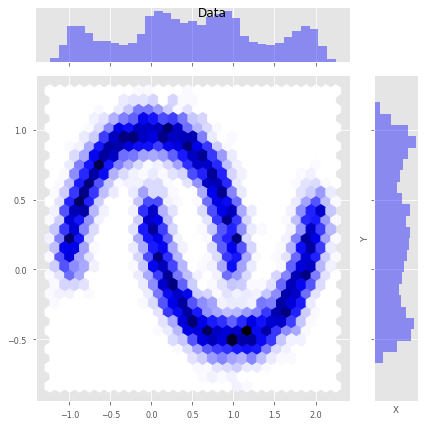

In [20]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'moons'
n_samples = 10_000
noise = 0.1
random_state=123
n_features = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state
).generate_samples()

plot_2d_joint(data, title='Data')

### Function: RBIG Block

This block represents the sequence of RBIG Transforms:

1. Marginal Gaussianization
2. Rotation

In [43]:
class GaussianizationBlock(BaseEstimator, TransformerMixin):
    def __init__(self, mg_params: Optional[Dict]={}, rot_params: Optional[Dict]={}) -> None:
        self.mg_params_ = mg_params
        self.rot_params_ = rot_params
        
    def __repr__(self):
        
        # loop through and get mg
        rep_str = ['MG Params:']
        rep_str += [f"{ikey}={iparam}" for ikey, iparam in self.mg_params_.items()]
        rep_str += ['\nRotation Params:']
        rep_str += [f"{ikey}={iparam}" for ikey, iparam in self.rot_params_.items()]
        return ' '.join(rep_str)
    
    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> None:
        
        # marginal transformation
        self.marginal_gaussian_ = HistogramGaussianization(**self.mg_params_)
        
        X = self.marginal_gaussian_.fit_transform(X)
        
        # rotation
        self.rotation_ = OrthogonalTransform(**self.rot_params_).fit(X)
        
        return self
    
    def transform(self, X: np.ndarray, y: Optional[np.ndarray] = None, return_jacobian=False) -> Tuple[np.ndarray, np.ndarray]:
        
        # marginal transformation
        Xmg = self.marginal_gaussian_.transform(X)
        
        # rotation
        Xtrans = self.rotation_.transform(Xmg)
        
        if not return_jacobian:
            return Xtrans
        else:
            dX_mg = self.marginal_gaussian_.log_abs_det_jacobian(X)
            dX_rot = self.rotation_.log_abs_det_jacobian(Xmg)
            return Xtrans, dX_mg + dX_rot
    
    def inverse_transform(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> np.ndarray:
        
        # rotation transpose
        X = self.rotation_.inverse_transform(X)
        
        # inverse marginal gaussianization
        X = self.marginal_gaussian_.inverse_transform(X)
        return X
        
    def log_abs_det_jacobian(self, X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        
        # marginal transformation
        Xmg = self.marginal_gaussian_.transform(X)
        dX_mg = self.marginal_gaussian_.log_abs_det_jacobian(X)
        
        # rotation
        dX_rot = self.rotation_.log_abs_det_jacobian(Xmg)
        
        return dX_mg + dX_rot

### Psuedo-Code

1. Add Flow to iterable
2. Do Transformation (MG + Rot)
3. Check CallBack
    * Stopping Criteria - hard stop after layers
    * Total Correlation - Calculate marginal entropy
    * Negative Log-Likelihood - score
4. Check Convergence
    * If Done: repeat steps 1-3
    * Else: End training

In [44]:
import collections

In [45]:
class BlockParams(NamedTuple):
    # marginal transform parameters
    nbins        : int = 100
    alpha        : float = 1e-6
    # rotation parameters
    rotation     : str = 'ica'
    random_state : int = 123
    rot_kwargs   : Dict = {}
    
    def fit_data(self, X: np.ndarray) -> GaussianizationBlock:
        
        # initialize RBIG Block
        gauss_block = GaussianizationBlock(
            mg_params={
                'nbins': self.nbins,
                'alpha': self.alpha,
            },
            rot_params={
                'rotation': self.rotation,
                'random_state': self.random_state,
                'kwargs': self.rot_kwargs
            }
        )
         
        return gauss_block.fit(X)

In [46]:
rbig_block = BlockParams(rotation='ica')
# rbig_block.rotation = 'pca'

rbig_block = rbig_block.fit_data(data)
rbig_block

MG Params: nbins=100 alpha=1e-06 
Rotation Params: rotation=ica random_state=123 kwargs={}

<Figure size 360x360 with 0 Axes>

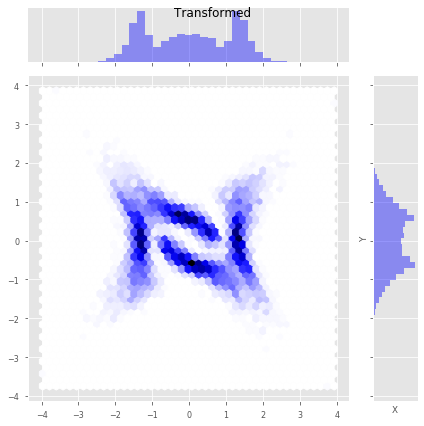

<Figure size 360x360 with 0 Axes>

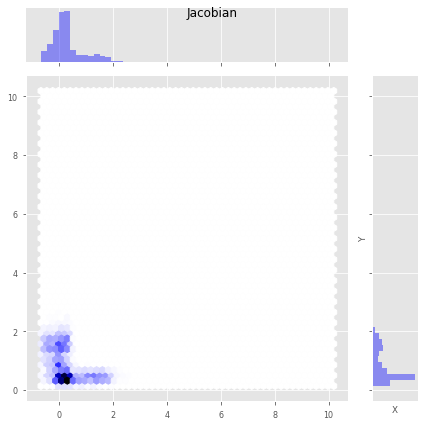

In [47]:

X_trans, dX_trans = rbig_block.transform(data, None, True)

plot_2d_joint(X_trans, title='Transformed')
plot_2d_joint(dX_trans, title='Jacobian')

<Figure size 360x360 with 0 Axes>

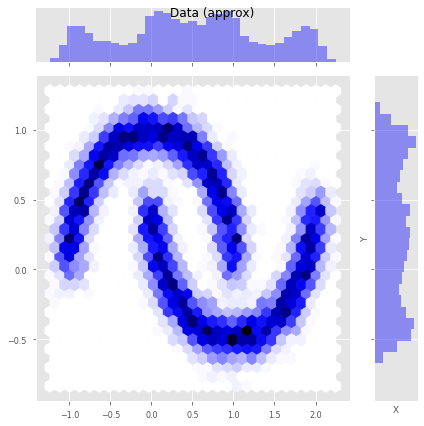

In [48]:
data_approx = rbig_block.inverse_transform(X_trans)
plot_2d_joint(data_approx, title='Data (approx)')

In [60]:

class GaussianizationFlowModel(BaseEstimator, DensityTransformerMixin, ScoreMixin):
    """A sequence of Gaussianization transforms.
    
    Parameters
    ----------
    """

    def __init__(self, flow: BlockParams, n_layers: int=10, ) -> None:
        self.flow = flow
        self.n_layers = n_layers

    def fit(self, X: np.ndarray, y: Optional[np.ndarray] = None) -> None:
        
        # initialize transforms
        self.flows = list()
        self.nll_loss = list()
        X_logdetjacobian = np.zeros(shape=X.shape)
        self.n_features_ = X.shape[1]
        
        for ilayer in range(self.n_layers):
            
            # initialize rbig block
            iflow = self.flow.fit_data(X)
                        
            # transform data
            X, dX = iflow.transform(X, y=None, return_jacobian=True)
            
            # add
            dX[dX > 0.0] = 0.0
            
            X_logdetjacobian += dX
            self.nll_loss.append(np.mean(stats.norm().logpdf(X) + X_logdetjacobian))
            
            self.flows.append(iflow)
            
        
        #
        return self
    
    def transform(self, X: np.ndarray, y: Optional[np.ndarray] = None, return_jacobian=False) -> np.ndarray:
        
        
        X_slogdet = np.zeros(shape=X.shape)
        for iflow in self.flows:
            
            X, dX = iflow.transform(X, None, return_jacobian=True)
            
            X_slogdet += dX
        
        return X, X_slogdet

    def inverse_transform(
        self, X: np.ndarray, y: Optional[np.ndarray] = None
    ) -> np.ndarray:
        
        for iflow in self.flows[::-1]:
            
            X = iflow.inverse_transform(X)
        return X


    def score_samples(self, X: np.ndarray, y: Optional[np.ndarray]=None) -> np.ndarray:
        
        # transform
        
        Z, dX = self.transform(X)
        prior_logprob = stats.norm().logpdf(Z).sum(axis=1)
        
        # get rid of extreme values
        dX[dX > 0.0] = 0.0
        return prior_logprob + dX.sum(axis=1)

    def sample(self, n_samples: int=1) -> np.ndarray:
        
        Z = stats.norm().rvs((n_samples, self.n_features_))
        return self.inverse_transform(Z)

<Figure size 360x360 with 0 Axes>

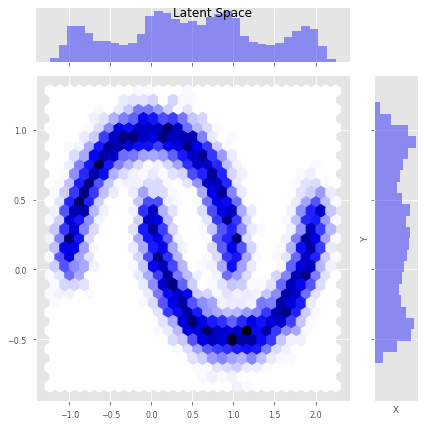

In [61]:
plot_2d_joint(data, title='Latent Space')



In [86]:
# initialize params
block_params = BlockParams(rotation='pca')

# initialize gaussianization flow model
n_layers = 100
rbig_model = GaussianizationFlowModel(block_params, n_layers=n_layers)
rbig_model.fit(data);


### Viz - Forward Transformation, Latent Space Z

<Figure size 360x360 with 0 Axes>

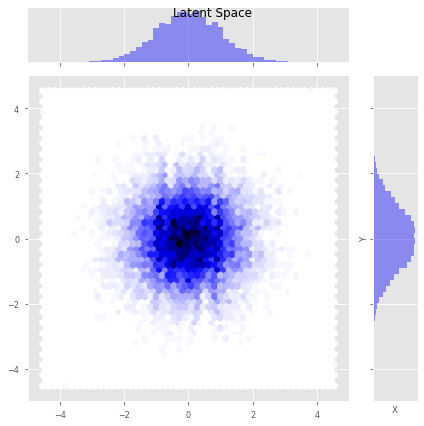

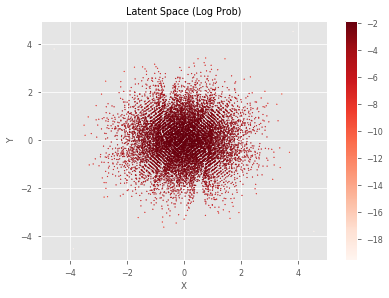

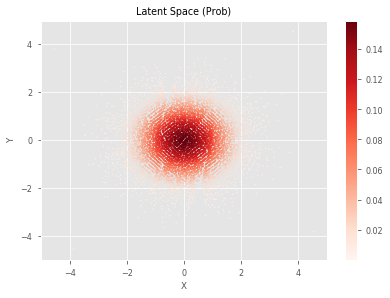

In [87]:
Z, X_slogdzet = rbig_model.transform(data)
plot_2d_joint(Z, title='Latent Space')

X_priorprob = stats.norm().logpdf(Z)


plot_prob(Z, X_priorprob.sum(axis=1), title='Latent Space (Log Prob)')
plot_prob(Z, np.exp(X_priorprob.sum(axis=1)), title='Latent Space (Prob)')

### Viz - Inverse Transformation, Data Space X

<Figure size 360x360 with 0 Axes>

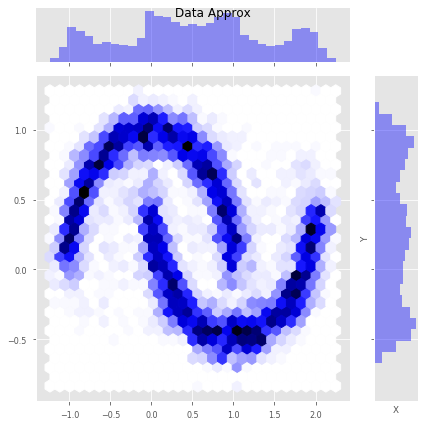

In [88]:
Z_samples = stats.norm().rvs((10_000, 2))
data_approx = rbig_model.inverse_transform(Z_samples)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Sampling, Data Space X

<Figure size 360x360 with 0 Axes>

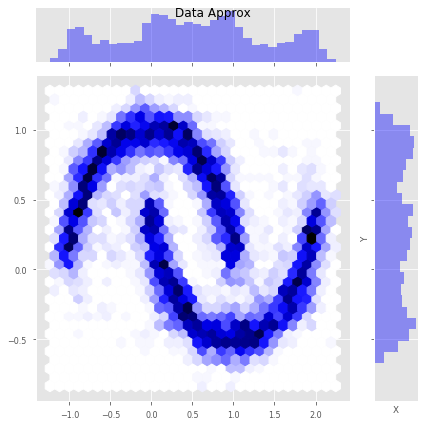

In [89]:
data_approx = rbig_model.sample(10_000)
plot_2d_joint(data_approx, title='Data Approx')

### Viz - Probabilities, Data Space X

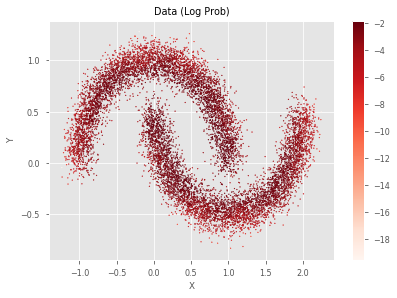

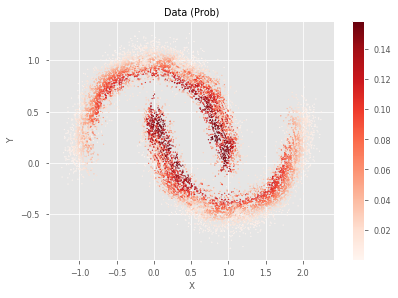

In [90]:
X_prob = rbig_model.score_samples(data)

plot_prob(data, X_prob, title='Data (Log Prob)')
plot_prob(data, np.exp(X_prob), title='Data (Prob)')

In [96]:
X_nll = rbig_model.score(data, None)
print('Negative Log-Likelihood:',X_nll)
print('Negative Likelihood:',np.exp(X_nll))

Negative Log-Likelihood: -3.2467392946984486
Negative Likelihood: 0.03890084544853361


### Viz - Negative Log-Likelihood

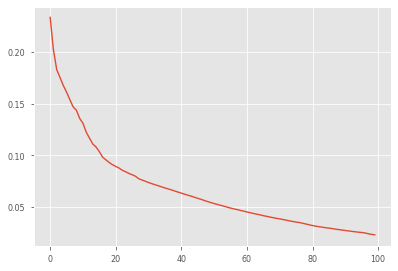

In [92]:
plt.plot(np.exp(rbig_model.nll_loss))

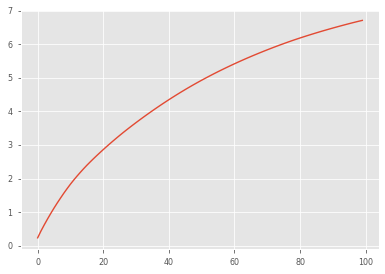

In [95]:
plt.plot(np.cumsum(np.exp(rbig_model.nll_loss)))